<a href="https://colab.research.google.com/github/TectoArc/Carbon-Predictions/blob/main/All_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_style('dark')
plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

In [3]:
df = pd.read_excel("Dataset_M.xlsx", skiprows=1)
df = df.drop(columns=["Reference","Sample Number"], axis=1)
df.head()

,Pressure (Gpa),Temperature (°C),Fe,Ni,S,C
0,0.001,1200,92.096944,7.903056,0.0,3.8
1,0.001,1250,91.239316,8.760684,0.0,3.6
2,0.001,1280,89.281998,10.718002,0.0,3.3
3,0.001,1310,90.758048,9.241952,0.0,3.0
4,0.001,1360,91.215526,8.784474,0.0,2.4


In [4]:
print(df.shape, df.columns)

(336, 6) Index(['Pressure (Gpa)', 'Temperature (°C)', 'Fe', 'Ni', 'S', 'C'], dtype='object')


# Plotting

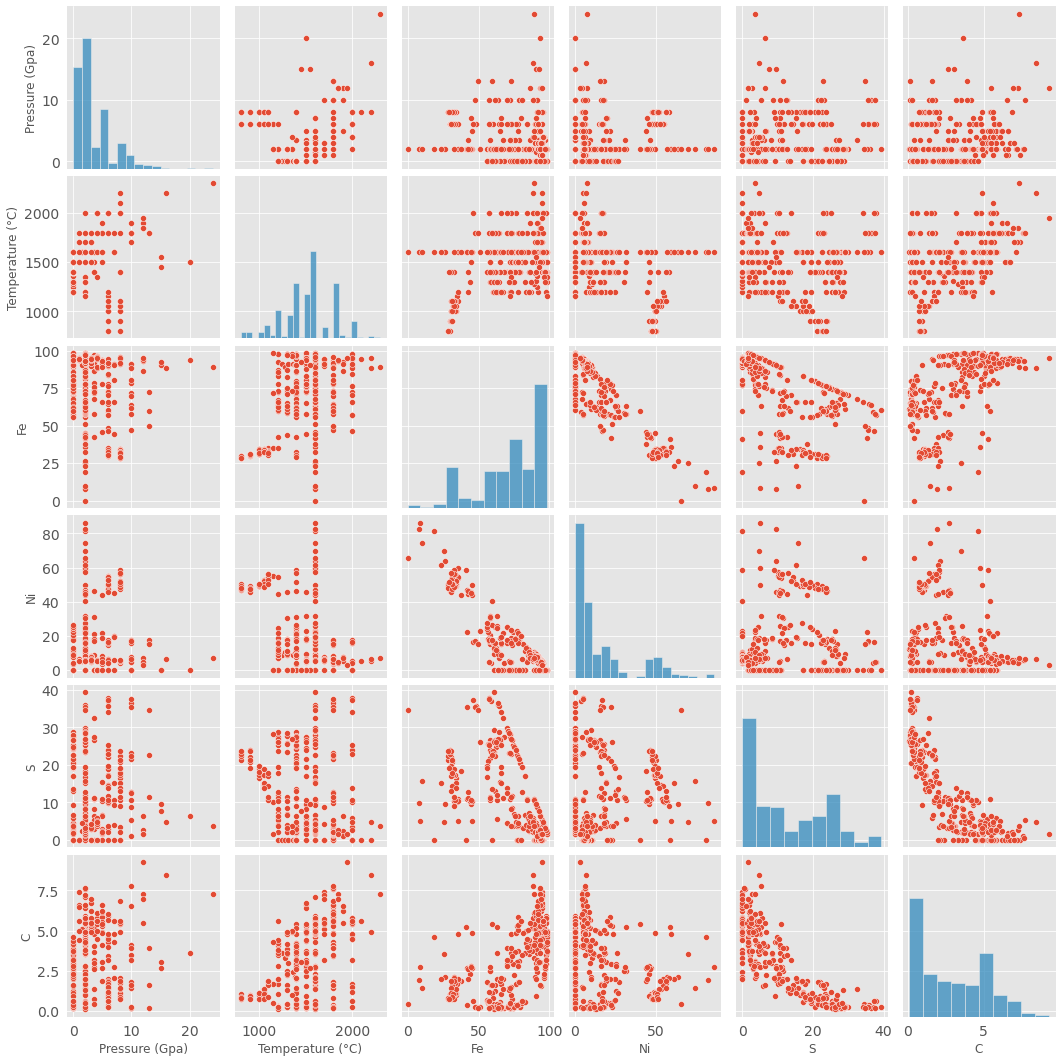

In [5]:
sns = sns.pairplot(df)
#sns.savefig("Pairplot.eps", dpi=1600)
#plt.show()

# Split the dataset and scale

In [5]:
X  = df.drop('C', axis = 1)
y = df['C']

In [6]:
X.head(); y.head()

0    3.8
1    3.6
2    3.3
3    3.0
4    2.4
Name: C, dtype: float64

In [7]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost

In [ ]:
import xgboost
from sklearn.utils.fixes import loguniform

xgb = xgboost.XGBRegressor()

In [ ]:
colsample_bytree = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
boost_params = ["gblinear", "gbtree"]
base_score = [0.15,0.25,0.50,0.75,1.0]
max_depth = [2,3,4,5,6,7,8,9,10]
learning_rate= [0.025,0.5,0.1,0.125,0.15,0.2]
min_child_weight = [1,3,5,7,9]
n_estimators = [100,150,200,250,300,350,400,500,600]


params = {
    "colsample_bytree":colsample_bytree,
    "boost_params":boost_params,
    "max_depth":max_depth,
    "learning_rate":learning_rate,
    "min_child_weight":min_child_weight,
    "n_estimators":n_estimators,
    "base_score":base_score
}

xgb_opt = RandomizedSearchCV(xgb, param_distributions=params, cv=10, scoring='r2', n_jobs=-1, n_iter=50, random_state=100)
xgb_opt.fit(X_train_scaled, y_train)

[09:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha...
                                        'boost_params': ['gblinear', 'gbtree'],
                                        'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                           

In [ ]:
xgb_opt.best_estimator_

XGBRegressor(base_score=0.75, boost_params='gblinear', booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             gamma=0, importance_type='gain', learning_rate=0.025,
             max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_reg = xgboost.XGBRegressor(base_score=0.75, boost_params='gblinear', booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             gamma=0, importance_type='gain', learning_rate=0.025,
             max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
y_xgb = xgb_reg.fit(X_train_scaled, y_train).predict(X_test_scaled)

[09:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


The absolute error for the XGBOOST Model : 0.3891687764192448
The mean squared error for the XGBOOST Model : 0.5617500497111888
The R2-score for the XGBOOST Model : 0.9341678269575443


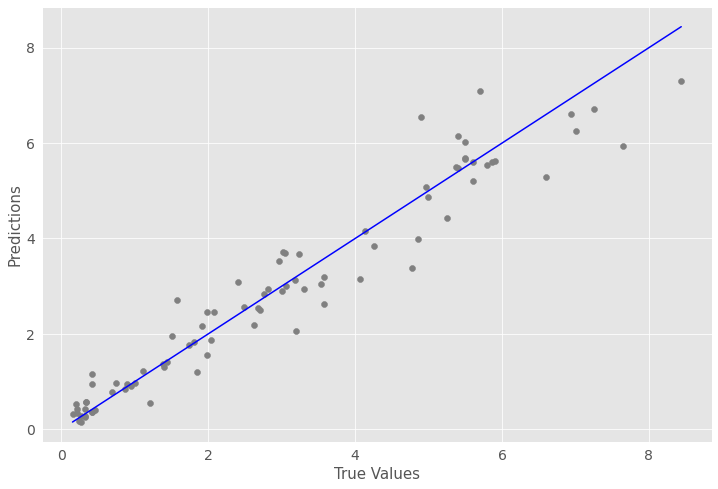

In [ ]:
MAE = mean_absolute_error(y_test, y_xgb)
MSE = mean_squared_error(y_test, y_xgb)
R2_xg = r2_score(y_test, y_xgb)
RMSE = np.sqrt(MSE)


print("The absolute error for the XGBOOST Model :", MAE)
print("The mean squared error for the XGBOOST Model :", RMSE)
print("The R2-score for the XGBOOST Model :", R2_xg)
plt.figure(figsize = (12,8))
plt.scatter(y_test, y_xgb, color = 'grey')
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_xgb), max(y_test))
p2 = min(min(y_xgb), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()

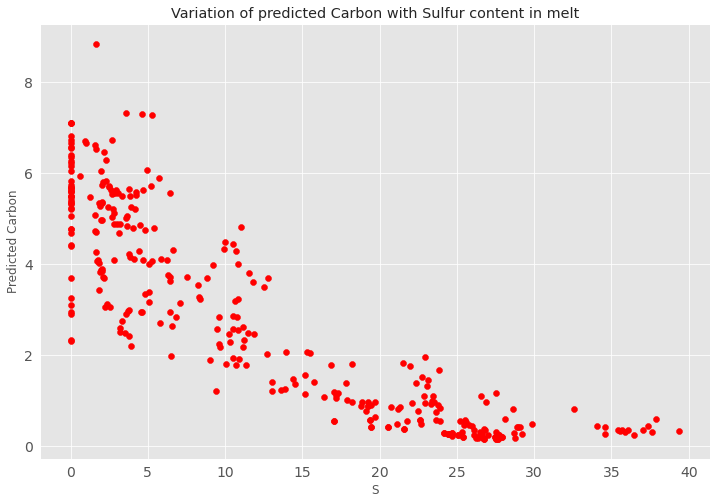

In [ ]:
X_scale = scaler.transform(X)

y_pred_xgb = xgb_reg.predict(X_scale)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_xgb, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [ ]:
XGB = pd.DataFrame(y_pred_xgb, columns=['XGB'])
XGB.head()

,XGB
0,3.696164
1,3.251955
2,2.945771
3,2.887612
4,3.093560


In [ ]:
#df_xgb.to_excel('Carbon_XGBOOST_Predictions(M).xlsx')

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
params = {'n_estimators' : [100,150,200,250,300,350,400,500,600],
              'max_features' : ['auto','sqrt'],
              'max_depth' : [10,20,30,40,50,60,70,80,90,100],
              'min_samples_split' : [2,3,4,5,6,7,8,9,10],
              'min_samples_leaf' : [1,2,4,6],
              'bootstrap' : [True, False]}
rf_opt = RandomizedSearchCV(estimator = rf, param_distributions = params, scoring = 'r2', n_iter = 50, cv = 10, n_jobs = -1, random_state=100)
rf_opt.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [ ]:
rf_opt.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
rf_reg = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_rf = rf_reg.fit(X_train_scaled, y_train).predict(X_test_scaled)

The absolute error for the Random Forest Model : 0.35546268752138654
The mean squared error for the Random Forest Model : 0.5149415795688815
The R2-score for the Random Forest Model : 0.9446818212189544


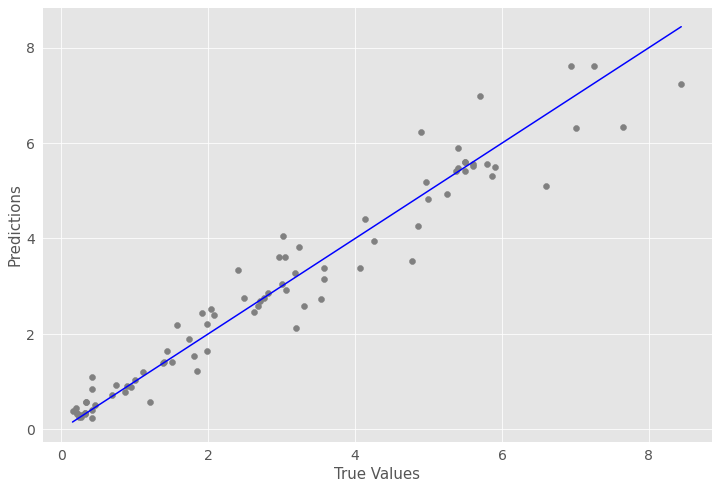

<Figure size 432x288 with 0 Axes>

In [ ]:
MAE = mean_absolute_error(y_test, y_rf)
MSE = mean_squared_error(y_test, y_rf)
R2_rf = r2_score(y_test, y_rf)
RMSE = np.sqrt(MSE)


print("The absolute error for the Random Forest Model :", MAE)
print("The mean squared error for the Random Forest Model :", RMSE)
print("The R2-score for the Random Forest Model :", R2_rf)
plt.figure(figsize = (12,8))
plt.scatter(y_test, y_rf, color = 'grey')
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_rf), max(y_test))
p2 = min(min(y_rf), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()
plt.savefig('Random Forest-model-2000dpi.eps', orientation='landscape', dpi=1600)

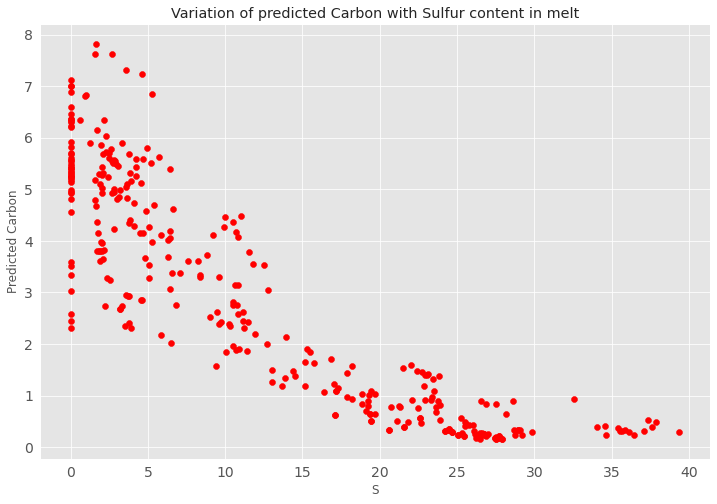

In [ ]:
X_scale = scaler.transform(X)

y_pred_rf = rf_reg.predict(X_scale)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_rf, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [ ]:
RF = pd.DataFrame(y_pred_rf, columns=["RF"])
RF.head()

,RF
0,3.591630
1,3.508549
2,2.584949
3,3.038100
4,3.337426


In [ ]:
#df_rf.to_excel("Random Forest predictions.xlsx")

# Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
grids = {
    'n_estimators': [100,150,200,250,300,350,400,500,600],
    'criterion': ['mse', 'mae'],
    'max_depth': [2,8,16,32,50],
    'max_features': ['auto','sqrt','log2'],    
    'bootstrap': [True, False],
    'warm_start': [True, False],
}

extr_optimize = RandomizedSearchCV(model, param_distributions = grids, cv = 10, scoring = 'r2', n_jobs = -1, n_iter = 50, random_state = 100)
extr_optimize.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=Fals...
                   iid=

In [ ]:
extr_optimize.best_estimator_

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=16, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=150, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=True)

In [ ]:
model_extr = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                    max_depth=32, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=500, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=True)

In [ ]:
y_extr = model_extr.fit(X_train_scaled, y_train).predict(X_test_scaled)

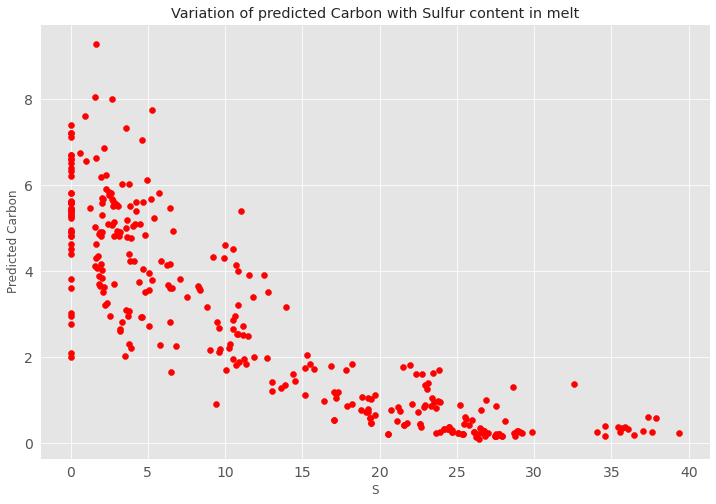

In [ ]:
X_scale = scaler.transform(X)
y_pred_extr = model_extr.predict(X_scale)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_extr, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [ ]:
EXTR = pd.DataFrame(y_pred_extr, columns=['EXTR'])
EXTR.head()

,EXTR
0,3.800000
1,3.600000
2,2.755392
3,2.955300
4,3.024585


# Voting Regressor 

In [ ]:
from sklearn.ensemble import VotingRegressor

reg1 = xgb_reg 
reg2 = rf_reg 
reg3 = model_extr

v_reg = VotingRegressor([('xgb', reg1), ('rf', reg2), ('et', reg3)])
v_reg.fit(X_train_scaled, y_train)

[19:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=0.75,
                                          boost_params='gblinear',
                                          booster='gbtree', colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.6, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.025, max_delta_step=0,
                                          max_depth=4, min_child_weight=3,
                                          missing=None, n_estimators=500,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_stat...
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criteri

In [ ]:
v_pred = v_reg.predict(X_test_scaled)

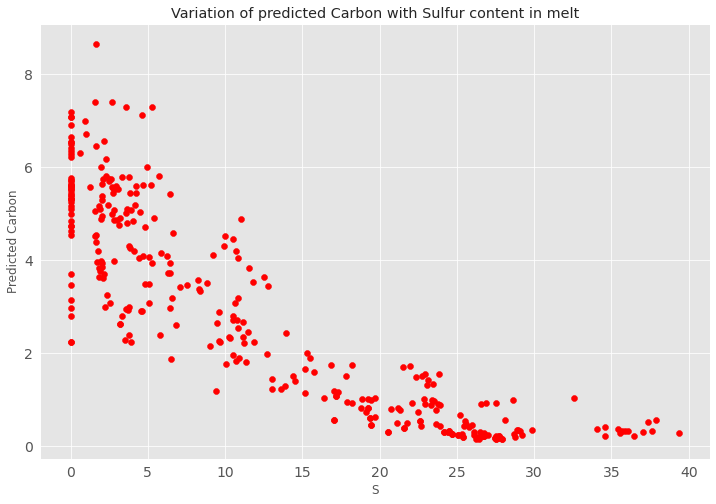

In [ ]:
X_scale = scaler.transform(X)

y_pred_v = v_reg.predict(X_scale)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_v, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [ ]:
V = pd.DataFrame(y_pred_v, columns=['VR'])
V.head()

,VR
0,3.696408
1,3.461114
2,2.798455
3,2.972915
4,3.142372


In [ ]:
#df_v.to_excel("Voting regressor.xlsx")

# Linear Regression 

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV

r_cv = RidgeCV()
r_cv.fit(X_train_scaled, y_train)
r_alpha = r_cv.alpha_
r_alpha

1.0

In [10]:
linear = LinearRegression()
ridge = Ridge(r_alpha)

In [11]:
y_linear = linear.fit(X_train_scaled, y_train).predict(X_test_scaled)
y_ridge = ridge.fit(X_train_scaled, y_train).predict(X_test_scaled)

In [12]:
df_predictions = pd.DataFrame({'y_test' : y_test,
                               'linear' : y_linear,
                               'ridge' : y_ridge,})
df_predictions.head()

,y_test,linear,ridge
195,1.380000,1.634663,1.633093
141,4.136693,3.955617,3.952329
63,0.240000,0.574845,0.583762
125,1.440000,1.696456,1.691764
331,7.250000,6.041346,6.033673


In [13]:
coefficients = pd.DataFrame({'Features':X_train.columns})
coefficients['linear'] = linear.coef_
coefficients['ridge'] = ridge.coef_

coefficients

,Features,linear,ridge
0,Pressure (Gpa),0.333607,0.332951
1,Temperature (°C),0.453105,0.451886
2,Fe,0.582538,0.581703
3,Ni,0.270616,0.268140
4,S,-1.561041,-1.555455


In [15]:
R2_r = r2_score(df_predictions['y_test'], df_predictions['ridge'])
R2_l = r2_score(df_predictions['y_test'], df_predictions['linear'])
print("R2 Ridge : ", R2_r)
print("R2 Linear : ", R2_l)

R2 Ridge :  0.8365930581009489
R2 Linear :  0.8369779624125805


The absolute error for the Linear Model : 0.7112606100641802
The mean squared error for the Linear Model : 0.8839896548680587


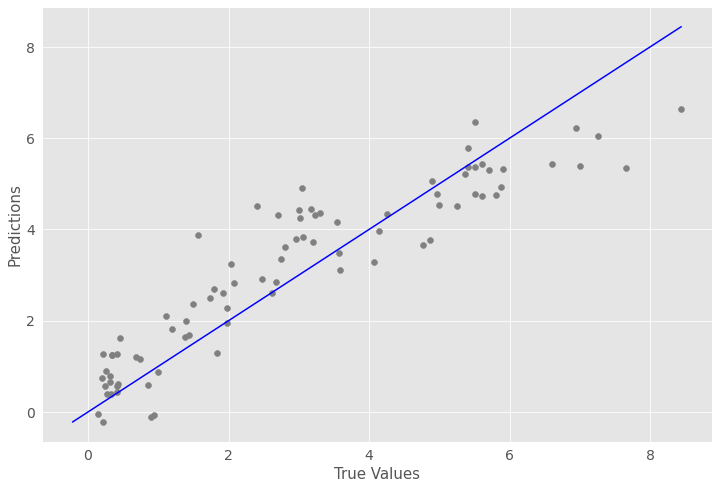

In [16]:
MAE = mean_absolute_error(df_predictions['y_test'], df_predictions['linear'])
MSE = mean_squared_error(df_predictions['y_test'], df_predictions['linear'])
RMSE = np.sqrt(MSE)


print("The absolute error for the Linear Model :", MAE)
print("The mean squared error for the Linear Model :", RMSE)

plt.figure(figsize = (12,8))
plt.scatter(y_test, y_linear, color = 'grey')
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_linear), max(y_test))
p2 = min(min(y_linear), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()

The absolute error for the Ridge Model : 0.7129486887241635
The mean squared error for the Ridge Model : 0.885032614559662


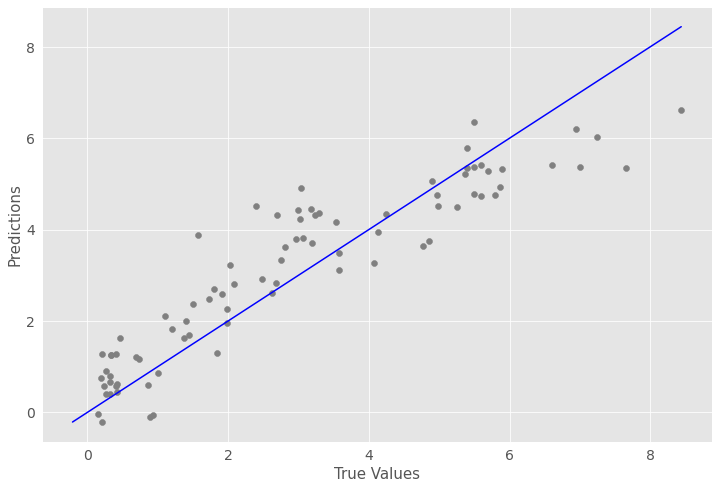

In [17]:
MAE = mean_absolute_error(df_predictions['y_test'], df_predictions['ridge'])
MSE = mean_squared_error(df_predictions['y_test'], df_predictions['ridge'])
RMSE = np.sqrt(MSE)


print("The absolute error for the Ridge Model :", MAE)
print("The mean squared error for the Ridge Model :", RMSE)

plt.figure(figsize = (12,8))
plt.scatter(y_test, y_ridge, color = 'grey')
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_ridge), max(y_test))
p2 = min(min(y_ridge), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()

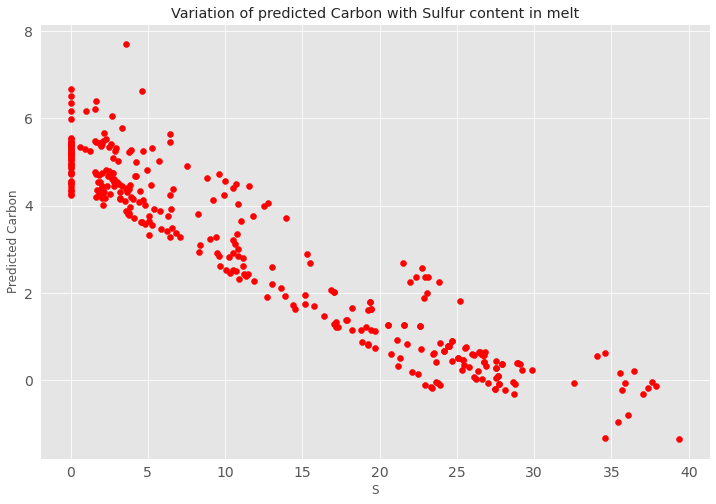

In [18]:
X_scale = scaler.transform(X)

y_pred_lr = linear.predict(X_scale)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_lr, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [19]:
LR = pd.DataFrame(y_pred_lr, columns=['LR'])
LR.head()

,LR
0,4.262493
1,4.333992
2,4.359861
3,4.426258
4,4.513281


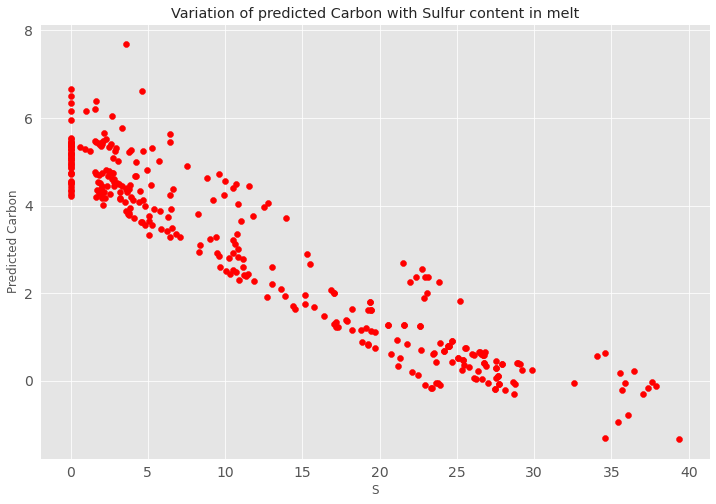

In [20]:
X_scale = scaler.transform(X)

y_pred_rr = ridge.predict(X_scale)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_rr, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [21]:
RR = pd.DataFrame(y_pred_rr, columns=['RR'])
RR.head()

,RR
0,4.258055
1,4.329249
2,4.354792
3,4.421204
4,4.508053


# K Nearest Neighbors Regression

In [ ]:
from sklearn import neighbors

rmse=[]
mae=[]
for k in range(2,25):
  knn = neighbors.KNeighborsRegressor(n_neighbors=k)

  knn.fit(X_train_scaled, y_train)
  y_knn = knn.predict(X_test_scaled)
  err1 = mean_absolute_error(y_test, y_knn)
  mae.append(err1)
  err2 = np.sqrt(mean_squared_error(y_test, y_knn))
  rmse.append(err2)
  print("For k={}, the rmse is :{}".format(k, err2))

For k=2, the rmse is :0.7882311155630431
For k=3, the rmse is :0.7945234783772053
For k=4, the rmse is :0.7626036156858585
For k=5, the rmse is :0.7557359143550225
For k=6, the rmse is :0.7631595759687337
For k=7, the rmse is :0.7451417771802776
For k=8, the rmse is :0.7534844878806443
For k=9, the rmse is :0.7674662223580295
For k=10, the rmse is :0.7950818375878389
For k=11, the rmse is :0.8169920406407564
For k=12, the rmse is :0.8627268166327962
For k=13, the rmse is :0.8572732930032684
For k=14, the rmse is :0.855073647315657
For k=15, the rmse is :0.8885571577084318
For k=16, the rmse is :0.8986211983775187
For k=17, the rmse is :0.9146781465782045
For k=18, the rmse is :0.9292315674076165
For k=19, the rmse is :0.9329867070905274
For k=20, the rmse is :0.9465857386167599
For k=21, the rmse is :0.9539075387826139
For k=22, the rmse is :0.9684507693263794
For k=23, the rmse is :0.9751291930221451
For k=24, the rmse is :0.9693328650253266


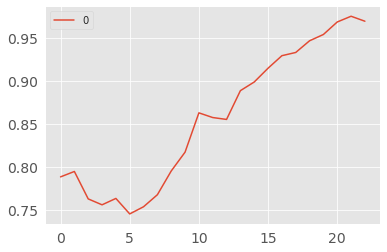

In [ ]:
elbow_plot=pd.DataFrame(rmse)
elbow_plot.plot();

In [ ]:
model_knn = neighbors.KNeighborsRegressor(n_neighbors=7)
y_knn = model_knn.fit(X_train_scaled, y_train).predict(X_test_scaled)

The absolute error for the Ridge Model : 0.4936535090536642
The mean squared error for the Ridge Model : 0.7451417771802776


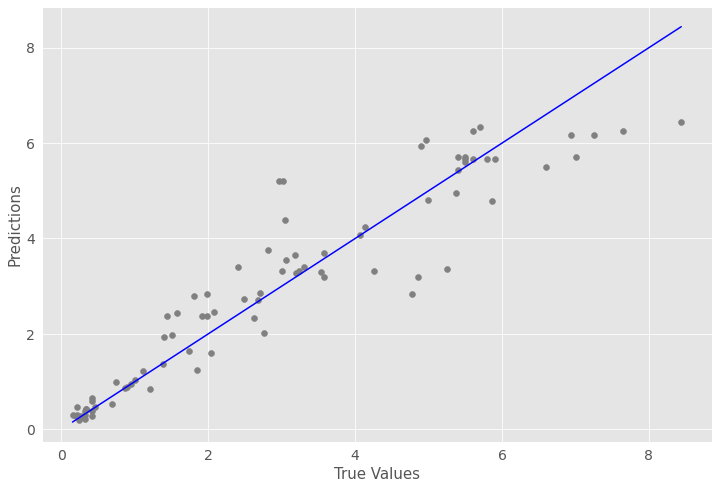

In [ ]:
MAE = mean_absolute_error(y_test, y_knn)
MSE = mean_squared_error(y_test, y_knn)
RMSE = np.sqrt(MSE)


print("The absolute error for the Ridge Model :", MAE)
print("The mean squared error for the Ridge Model :", RMSE)

plt.figure(figsize = (12,8))
plt.scatter(y_test, y_knn, color = 'grey')
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_knn), max(y_test))
p2 = min(min(y_knn), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()

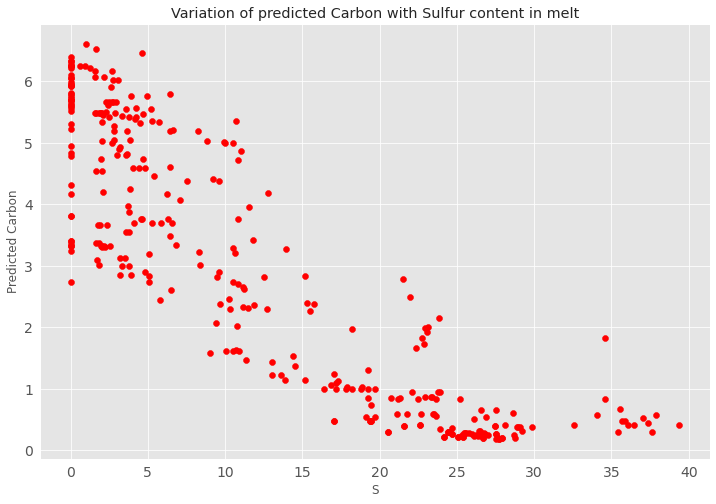

In [ ]:
X_scale = scaler.transform(X)

y_pred_knn = model_knn.predict(X_scale)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_knn, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [ ]:
KNR = pd.DataFrame(y_pred_knn, columns=["KNR"])
KNR.head()

,KNR
0,3.318319
1,3.245714
2,3.404034
3,3.325714
4,3.405714


# Polynomial Regression 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

poly_train = poly.fit_transform(X_train_scaled)
poly_test = poly.fit_transform(X_test_scaled)

In [ ]:
from sklearn.linear_model import LinearRegression

p_reg = LinearRegression()
p_reg.fit(poly_train, y_train)
y_poly = p_reg.predict(poly_test)
y_poly.flatten()

array([1.57228241, 4.00849857, 0.02485014, 1.22175674, 6.88434051,
       2.84595644, 1.06059076, 6.40877843, 0.74683572, 5.3195166 ,
       0.24063498, 4.92259147, 0.05955024, 2.01756574, 2.57465876,
       2.11518686, 0.9299112 , 1.49386156, 3.32994022, 0.49038812,
       0.56060028, 3.98898625, 3.13835685, 4.65447595, 4.74842378,
       5.88952207, 0.8171081 , 2.64511398, 5.52728226, 7.23631878,
       3.9341311 , 3.13645088, 2.39534157, 3.794228  , 2.43374365,
       0.16726136, 0.70269662, 1.54116011, 4.41958303, 0.35137385,
       0.6241074 , 5.92345947, 5.91497559, 0.63370348, 5.6575293 ,
       3.36523522, 4.38104004, 1.2816536 , 3.4320898 , 6.02070542,
       4.42260498, 2.16937894, 3.62396601, 3.58775624, 3.94759383,
       2.61618099, 7.57903809, 4.72154487, 6.00549072, 4.54469299,
       0.46584851, 5.61095947, 5.8976416 , 0.20960571, 0.87806317,
       4.01378376, 0.66905986, 2.03425236, 1.04604027, 2.37169266,
       0.35137385, 4.48919434, 0.55131234, 2.97356071, 6.65735

In [ ]:
print("MAE of quadratic polynomial regression: ", mean_absolute_error(y_test, y_poly.flatten()))
print("MSE of quadratic polynomial regression: ", mean_squared_error(y_test, y_poly.flatten()))

MAE of quadratic polynomial regression:  0.5280901841989195
MSE of quadratic polynomial regression:  0.5430266107664538


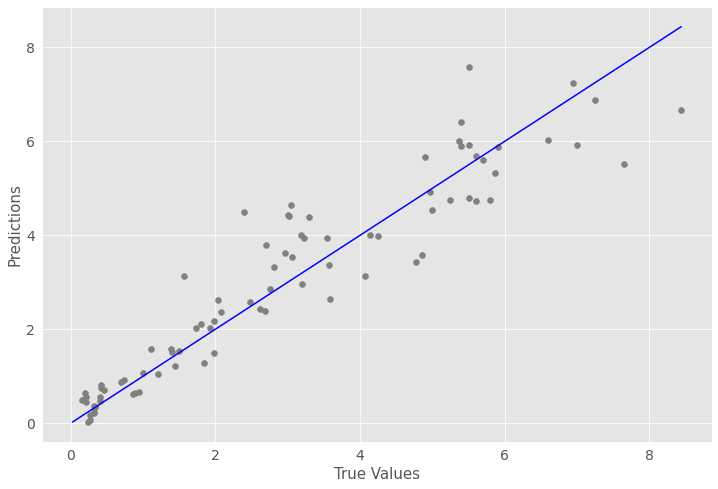

In [ ]:
plt.figure(figsize = (12,8))
plt.scatter(y_test, y_poly.flatten(), color = 'grey')
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_poly.flatten()), max(y_test))
p2 = min(min(y_poly.flatten()), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

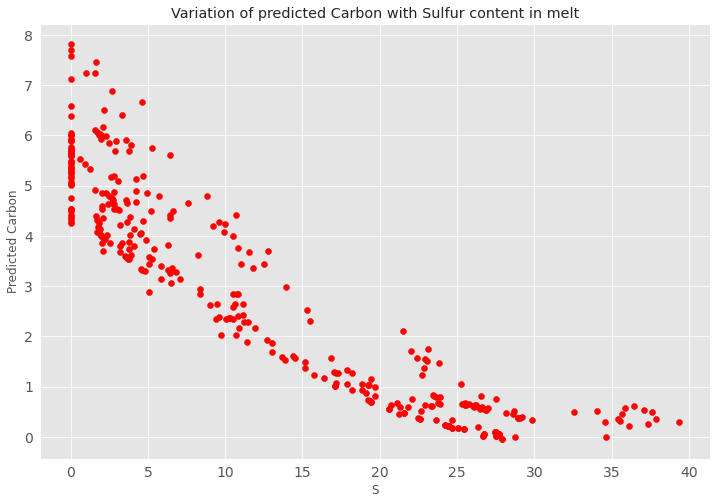

In [ ]:
X_scale = scaler.transform(X)
poly_X = poly.fit_transform(X_scale)
y_pred_poly = p_reg.predict(poly_X)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_poly, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [ ]:
PR = pd.DataFrame(y_pred_poly, columns=["PR"])
PR.head()

,PR
0,4.268613
1,4.340391
2,4.381040
3,4.422605
4,4.489194


# ADA BOOST

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor()

boost_params = ["linear", "square", "exponential"]
n_estimators = [100,400,700,1000,1300,1600]
learning_rate = [0.025,0.5,0.1,0.125,0.15,0.2]

grid = {
    'n_estimators' : n_estimators,
    'learning_rate' : learning_rate,
    'loss' : boost_params
}

ada_opt = RandomizedSearchCV(ada, param_distributions = grid, cv = 10, scoring = 'r2', n_jobs = 5, n_iter = 50, random_state = 702)
ada_opt.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=AdaBoostRegressor(base_estimator=None,
                                               learning_rate=1.0, loss='linear',
                                               n_estimators=50,
                                               random_state=None),
                   iid='deprecated', n_iter=50, n_jobs=5,
                   param_distributions={'learning_rate': [0.025, 0.5, 0.1,
                                                          0.125, 0.15, 0.2],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [100, 400, 700, 1000,
                                                         1300, 1600]},
                   pre_dispatch='2*n_jobs', random_state=702, refit=True,
                   return_train_score=False, scoring='r2', verbose=0)

In [ ]:
ada_opt.best_estimator_

AdaBoostRegressor(base_estimator=None, learning_rate=0.025, loss='square',
                  n_estimators=700, random_state=None)

In [ ]:
ada_reg = AdaBoostRegressor(base_estimator=None, learning_rate=0.025, loss='square',
                  n_estimators=700, random_state=None)

In [ ]:
y_ada = ada_reg.fit(X_train_scaled, y_train).predict(X_test_scaled)

The absolute error for the AdaBoost Model : 0.514012374313299
The mean squared error for the Adaboost Model : 0.6525240698571009
The R2-score for the AdaBoost Model : 0.9111729939363078


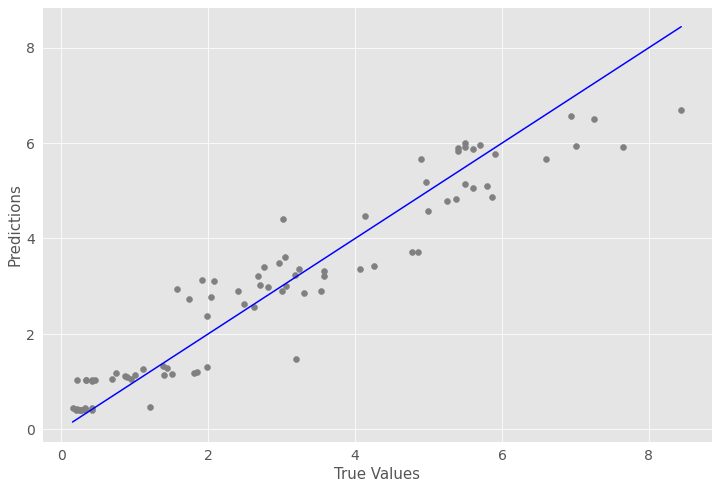

In [ ]:
MAE = mean_absolute_error(y_test, y_ada)
MSE = mean_squared_error(y_test, y_ada)
R2_rf = r2_score(y_test, y_ada)
RMSE = np.sqrt(MSE)


print("The absolute error for the AdaBoost Model :", MAE)
print("The mean squared error for the Adaboost Model :", RMSE)
print("The R2-score for the AdaBoost Model :", R2_rf)
plt.figure(figsize = (12,8))
plt.scatter(y_test, y_ada, color = 'grey')
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_ada), max(y_test))
p2 = min(min(y_ada), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()

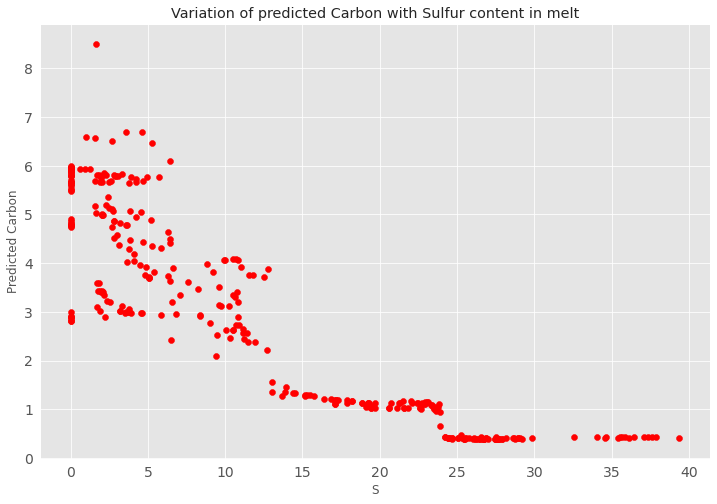

In [ ]:
y_pred_ada = ada_reg.predict(X_scale)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_ada, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [ ]:
ADA = pd.DataFrame(y_pred_ada, columns=['ADABOOST'])
ADA.head()

,ADABOOST
0,3.002143
1,2.913333
2,2.855556
3,2.892353
4,2.893333


# Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

criterion = ["mse", "friedman_mse", "mae", "poisson"]
splitter = ["best", "random"]
max_features = ["auto", "sqrt", "log2"]
max_depth = [1,2,3,4,5,6,7,8,9, None]
max_leaf_nodes = [2,3,5,7,9,None]
min_samples_split = [1,2,3,4,5,7,None]

params = {
    "criterion":criterion,
    "splitter":splitter,
    "max_features":max_features,
    "max_depth":max_depth,
    "max_leaf_nodes":max_leaf_nodes,
    "min_samples_split":min_samples_split
}

dt_opt = RandomizedSearchCV(dt, param_distributions=params, scoring='r2', n_iter = 50, cv = 10, n_jobs = -1, random_state=101)
dt_opt.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid='

In [ ]:
dt_opt.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=7,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
dt_reg = DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=7,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_dt = dt_reg.fit(X_train_scaled, y_train).predict(X_test_scaled)

The absolute error for the Decision Tree Model : 0.4420636218922336
The mean squared error for the Decision Tree Model : 0.6501104364123824
The R2-score for the Random Forest Model : 0.911828906342131


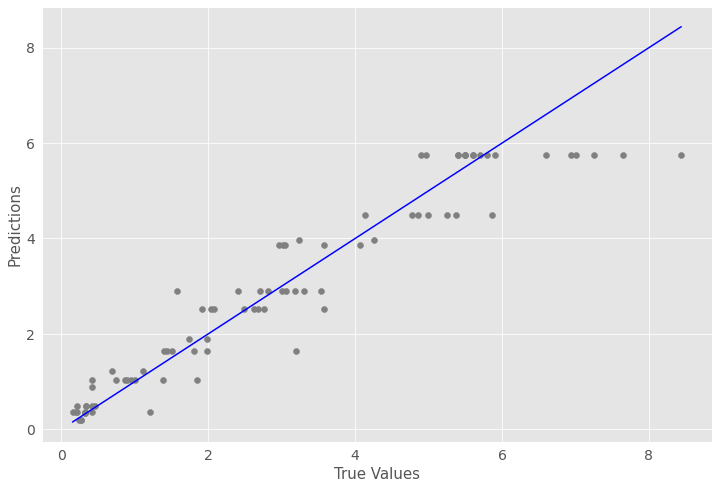

In [ ]:
MAE = mean_absolute_error(y_test, y_dt)
MSE = mean_squared_error(y_test, y_dt)
R2_rf = r2_score(y_test, y_dt)
RMSE = np.sqrt(MSE)


print("The absolute error for the Decision Tree Model :", MAE)
print("The mean squared error for the Decision Tree Model :", RMSE)
print("The R2-score for the Random Forest Model :", R2_rf)
plt.figure(figsize = (12,8))
plt.scatter(y_test, y_dt, color = 'grey')
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_dt), max(y_test))
p2 = min(min(y_dt), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()

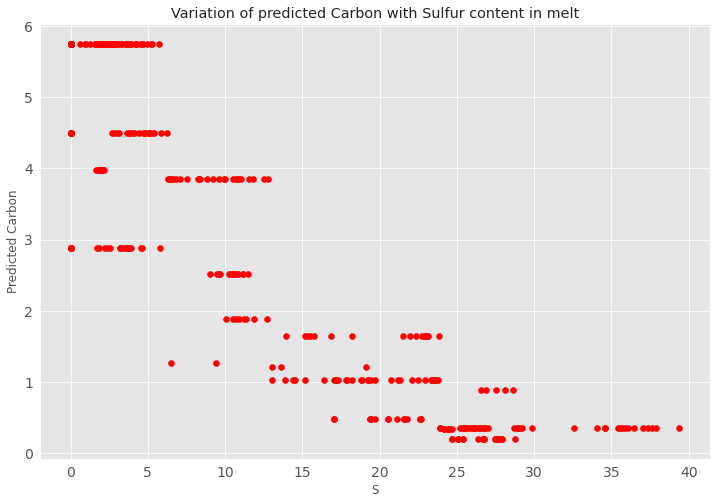

In [ ]:
y_pred_dt = dt_reg.predict(X_scale)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_dt, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [ ]:
DT = pd.DataFrame(y_pred_dt, columns=['DT'])
DT.head()

,DT
0,2.888
1,2.888
2,2.888
3,2.888
4,2.888


# Bayesian Ridge Regression

In [ ]:
from sklearn import linear_model

br = linear_model.BayesianRidge()
y_br = br.fit(X_train_scaled, y_train).predict(X_test_scaled)

The absolute error for the Bayesian Ridge Model : 0.712951341907143
The mean squared error for the Bayesian Ridge Model : 0.8850342847686113


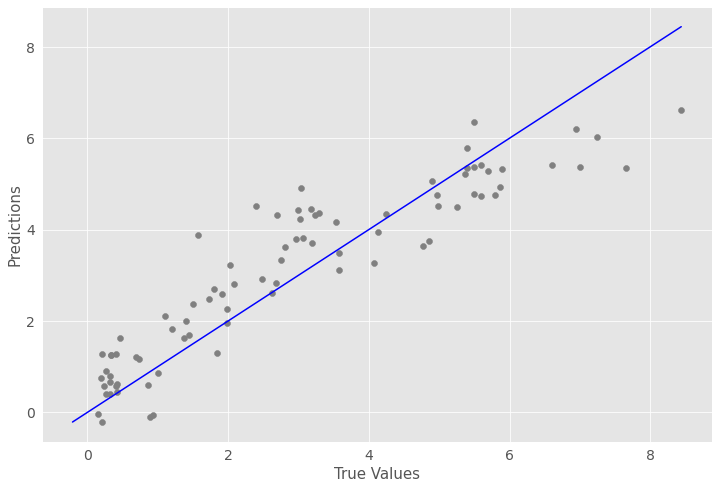

In [ ]:
MAE = mean_absolute_error(y_test, y_br)
MSE = mean_squared_error(y_test, y_br)
RMSE = np.sqrt(MSE)


print("The absolute error for the Bayesian Ridge Model :", MAE)
print("The mean squared error for the Bayesian Ridge Model :", RMSE)

plt.figure(figsize = (12,8))
plt.scatter(y_test, y_br, color = 'grey')
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_br), max(y_test))
p2 = min(min(y_br), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.show()

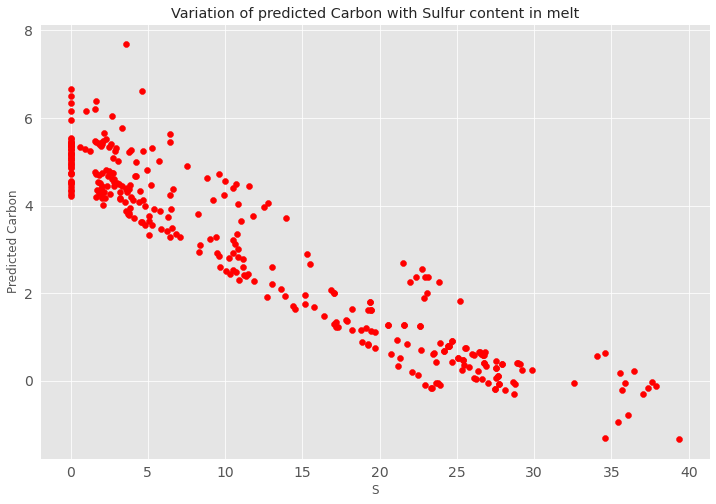

In [ ]:
X_scale = scaler.transform(X)

y_pred_br = br.predict(X_scale)

plt.figure(figsize= (12,8))
plt.scatter(df['S'], y_pred_br, color='r')
plt.xlabel('S')
plt.ylabel('Predicted Carbon')
plt.title('Variation of predicted Carbon with Sulfur content in melt')
plt.show()

In [ ]:
BR = pd.DataFrame(y_pred_br, columns=["BR"])
BR.head()

,BR
0,4.258048
1,4.329242
2,4.354784
3,4.421196
4,4.508045


# Neural Networks

In [ ]:
def format_output(data):
  y1 = data.pop('C')
  y1 = np.array(y1)
  return y1
  
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

def plot_diff(y_true, y_pred, title=''):
  plt.figure(figsize=(12,12))
  plt.scatter(y_true, y_pred)
  plt.xlabel('True values')
  plt.ylabel('Predictions')
  plt.title(title)
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.axis('equal')
  plt.axis('square')
  plt.show()

In [ ]:
train, test = train_test_split(df, test_size=0.3)
train_stats = train.describe()

# Get C as the output and format it into an numpy array 
train_stats.pop('C')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

#Normalize the training and testing data
norm_train_X = norm(train)
norm_test_X = norm(test)

#Define model layer
input_layer = Input(shape=len(train.columns),)
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)
fourth_dense = Dense(units='8', activation='relu')(third_dense)

#y1 output comes via the third dense
y1_output = Dense(units='1', name='y1_output')(fourth_dense)

#Define the model with an input layer and an output
model_nn = Model(inputs=input_layer, outputs=y1_output)
print(model_nn.summary())

#Specify the optimizer and compile the model with the loss functions of the output
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model_nn.compile(optimizer=optimizer,
              loss={'y1_output':'mse'},
              metrics={'y1_output':tf.keras.metrics.RootMeanSquaredError()})

plot_model(model_nn)

In [ ]:
#Train the model for 2000 epochs 
history = model_nn.fit(norm_train_X, train_Y, 
                       epochs=2000, batch_size = 10, validation_data=(norm_test_X, test_Y))

In [ ]:
#Test the model and print the loss and mse for both outputs
Y1_loss, Y1_rmse = model_nn.evaluate(x=norm_test_X, y=test_Y)
print('Y1_loss={}, Y1_rmse={}'.format(Y1_loss, Y1_rmse))

#Plot the loss and mse 
Y_pred = model_nn.predict(norm_test_X)
plot_diff(test_Y, Y_pred, title='C_Pred')
#plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE')

In [ ]:
df2 = df.copy()
df2 = df2.drop('C', axis=1)
df2.head()

,Pressure (Gpa),Temperature (°C),Fe,Ni,S
0,0.001,1200,92.096944,7.903056,0.0
1,0.001,1250,91.239316,8.760684,0.0
2,0.001,1280,89.281998,10.718002,0.0
3,0.001,1310,90.758048,9.241952,0.0
4,0.001,1360,91.215526,8.784474,0.0


In [ ]:
def scale(x):
  return (x - train_stats['mean']) / train_stats['std']

In [ ]:
df2_scaled = scale(df2)

pred_nn = model_nn.predict(df2_scaled)
plt.figure(figsize=(12,8))
plt.scatter(df2['S'].values, pred_nn, color='blue')
plt.ylabel('C')
plt.xlabel('S')
plt.title('Relation between Sulfur and Carbon content')
plt.show()

# Compiling the all models dataset

In [ ]:
df_compile = df.copy()
df_compile.head()

,Pressure (Gpa),Temperature (°C),Fe,Ni,S,C
0,0.001,1200,92.096944,7.903056,0.0,3.8
1,0.001,1250,91.239316,8.760684,0.0,3.6
2,0.001,1280,89.281998,10.718002,0.0,3.3
3,0.001,1310,90.758048,9.241952,0.0,3.0
4,0.001,1360,91.215526,8.784474,0.0,2.4


In [ ]:
df_compile["EXTRA TREES REGRESSION"] = EXTR["EXTR"]
df_compile["RANDOM FOREST REGRESSION"] = RF["RF"]
df_compile["XGBOOST REGRESSION"] = XGB["XGB"]
df_compile["VOTING REGRESSION"] = V["VR"]
df_compile["DECISION TREE REGRESSION"] = DT["DT"]
df_compile["ADABOOST REGRESSION"] = ADA["ADABOOST"]
df_compile["K NEIGHBORS REGRESSION"] = KNR["KNR"]
df_compile["RIDGE REGRESSION"] = RR["RR"]
df_compile["BAYESIAN RIDGE REGRESSION"] = BR["BR"]
df_compile["POLYNOMIAL REGRESSION"] = PR["PR"]
df_compile["LINEAR REGRESSION"] = LR["LR"]

In [ ]:
df_compile.head()

,Pressure (Gpa),Temperature (°C),Fe,Ni,S,C,EXTRA TREES REGRESSION,RANDOM FOREST REGRESSION,XGBOOST REGRESSION,DECISION TREE REGRESSION,ADABOOST REGRESSION,K NEIGHBORS REGRESSION,RIDGE REGRESSION,BAYESIAN RIDGE REGRESSION,POLYNOMIAL REGRESSION,LINEAR REGRESSION
0,0.001,1200,92.096944,7.903056,0.0,3.8,3.800000,3.591630,3.696164,2.888,3.002143,3.318319,4.258055,4.258048,4.268613,4.262493
1,0.001,1250,91.239316,8.760684,0.0,3.6,3.600000,3.508549,3.251955,2.888,2.913333,3.245714,4.329249,4.329242,4.340391,4.333992
2,0.001,1280,89.281998,10.718002,0.0,3.3,2.755392,2.584949,2.945771,2.888,2.855556,3.404034,4.354792,4.354784,4.381040,4.359861
3,0.001,1310,90.758048,9.241952,0.0,3.0,2.955300,3.038100,2.887612,2.888,2.892353,3.325714,4.421204,4.421196,4.422605,4.426258
4,0.001,1360,91.215526,8.784474,0.0,2.4,3.024585,3.337426,3.093560,2.888,2.893333,3.405714,4.508053,4.508045,4.489194,4.513281


In [ ]:
#df_compile.to_excel("ALL MODELS.xlsx")

# NEW-DATA

In [ ]:
df_O = pd.read_excel('Dataset_O.xlsx', skiprows=1)
print(df_O.shape, df_O.columns)
df_O.head()

(13, 6) Index(['Pressure (Gpa)', 'Temperature (°C)', 'Fe', 'Ni', 'S', 'C'], dtype='object')


,Pressure (Gpa),Temperature (°C),Fe,Ni,S,C
0,10,1450,65.000000,17.587992,17.412008,NaN
1,10,1450,61.335990,18.120805,20.543205,NaN
2,10,1450,74.646263,18.415260,6.938476,NaN
3,10,1450,64.730981,16.671870,18.597149,NaN
4,10,1450,64.065260,18.559701,17.375039,NaN


In [ ]:
df_O = df_O.drop(columns = ['C'], axis=1)
df_O.head()

,Pressure (Gpa),Temperature (°C),Fe,Ni,S
0,10,1450,65.000000,17.587992,17.412008
1,10,1450,61.335990,18.120805,20.543205
2,10,1450,74.646263,18.415260,6.938476
3,10,1450,64.730981,16.671870,18.597149
4,10,1450,64.065260,18.559701,17.375039


In [ ]:
y_o = scaler.transform(df_O)
pred_o = model_extr.predict(y_o)

In [ ]:
O = pd.DataFrame(pred_o, columns=['O_Pred_C'])
df_O["C_Pred"] = O['O_Pred_C']
df_O.head()

,Pressure (Gpa),Temperature (°C),Fe,Ni,S,C_Pred
0,10,1450,65.000000,17.587992,17.412008,1.682020
1,10,1450,61.335990,18.120805,20.543205,1.347662
2,10,1450,74.646263,18.415260,6.938476,3.646596
3,10,1450,64.730981,16.671870,18.597149,1.532249
4,10,1450,64.065260,18.559701,17.375039,1.667779


<Figure size 864x576 with 0 Axes>

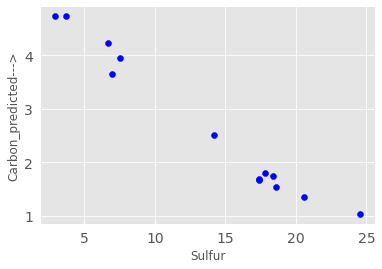

In [ ]:
plt.figure(figsize=(12,8))
fig,ax = plt.subplots()
plt.scatter(df_O['S'], pred_o, color='blue')
plt.ylabel('Carbon_predicted--->')
plt.xlabel('Sulfur')
fig.savefig("S4.eps", dpi=1600)
plt.show();

<Figure size 864x576 with 0 Axes>

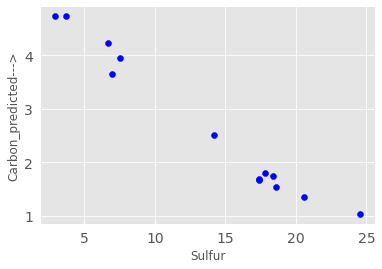

In [ ]:
plt.figure(figsize=(12,8))
fig,ax = plt.subplots()
plt.scatter(df_O['S'], pred_o, color='blue')
plt.ylabel('Carbon_predicted--->')
plt.xlabel('Sulfur')
fig.savefig("S4.jpeg", dpi=1600)
plt.show();

# Feature Importance 

In [ ]:
## All the model names : xgb_reg; rf_reg; model_extr; model_linear; model_ridge; model_knn;
# p_reg; dt_reg; ada_reg; br; 

In [ ]:
models = [xgb_reg, rf_reg, model_extr, ada_reg, dt_reg]
for model in models:
  print(model.feature_importances_)

[0.12323778 0.0803898  0.22165863 0.05170766 0.52300614]
[0.07175922 0.04517478 0.0323049  0.02660593 0.82415517]
[0.09049028 0.08676267 0.17296547 0.07204488 0.5777367 ]
[0.16647751 0.13876984 0.13700943 0.09198355 0.46575966]
[0.08548123 0.00329951 0.02623583 0.01438381 0.87059962]


In [ ]:
xgb_reg.feature_importances_

array([0.12323778, 0.0803898 , 0.22165863, 0.05170766, 0.52300614],
      dtype=float32)

array([ 0.33295036,  0.45188374,  0.58170218,  0.26813567, -1.55544609])